## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import glob


In [2]:
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

## Define SiVs 

In [3]:
# Create SiVs:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

### SiV related plots

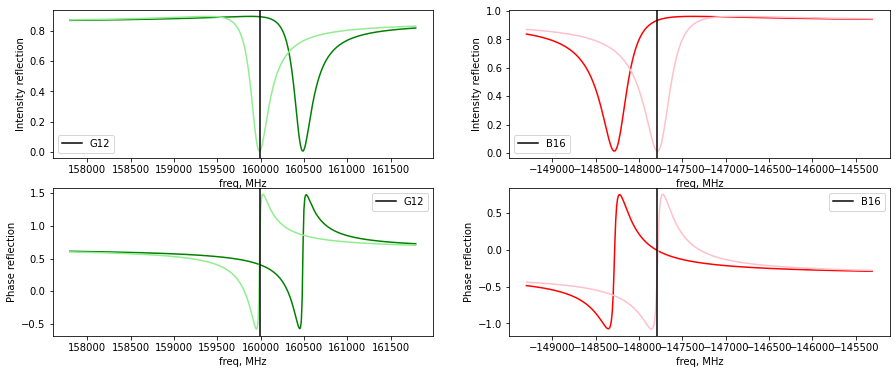

In [4]:
## Plot 
# generate plots of reflectivity

wl_A = siv_a.get_plotaxis()
wl_B = siv_b.get_plotaxis()

wl_read_optimum_A = siv_a.freq_optimum()
wl_read_optimum_B = siv_b.freq_optimum()

figure, ax = plt.subplots(2, 2, figsize=(15, 6))

ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['refl_refl'])**2, color = 'green')
ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['nonrefl_refl'])**2,color = 'lightgreen')
ax[0,0].set_xlabel('freq, MHz')
ax[0,0].set_ylabel('Intensity reflection')
ax[0,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[0,0].legend()

ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['refl_refl'])**2, color = 'red')
ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['nonrefl_refl'])**2, color = 'pink')
ax[0,1].set_xlabel('freq, MHz')
ax[0,1].set_ylabel('Intensity reflection')
ax[0,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[0,1].legend()

ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['refl_refl']), color = 'green')
ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['nonrefl_refl']),color = 'lightgreen')
ax[1,0].set_xlabel('freq, MHz')
ax[1,0].set_ylabel('Phase reflection')
ax[1,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[1,0].legend()

ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['refl_refl']), color = 'red')
ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['nonrefl_refl']), color = 'pink')
ax[1,1].set_xlabel('freq, MHz')
ax[1,1].set_ylabel('Phase reflection')
ax[1,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[1,1].legend()

plt.show()

### Move the SiV to the desired contrast point

In [5]:
siv_b.set_contrast(50)
siv_a.set_contrast(15)

new contrast 52.71006248179681
new contrast 17.96184388854666


## Setup single Node experiments in B16

In [6]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge

# Create Simulation:
sim = BlindComputing(b16_network)

In [7]:
# Setup errors and losses in the system:
contrast = siv_a.get_best_contrast()
print("Node A contrast = ", contrast)
contrast = siv_b.get_best_contrast()
print("Node B contrast = ", contrast)



Node A contrast =  17.96184388854666
Node B contrast =  52.71006248179681


## Single blind gates with electron as a function of phi

In [8]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

mu = 0.05
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, 8*np.pi/8]
phi2 = 0
phi3 = 0

n_rounds = 2
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

for j in range(len(phi1)):

    xp_array = np.empty((0, n_col), dtype=float)
    rho_init_xp_array = np.empty((2, 2), dtype=float)

    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    for i in range(n_rounds): 
        rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    # Average the data and save as a dict
    i = 0
    output_xp_mean_cl = np.mean(xp_array[:, i])
    output_xp_std_cl = np.std(xp_array[:, i], ddof=1)
    i = 3
    output_xp_mean_s = np.mean(xp_array[:, i])
    output_xp_std_s = np.std(xp_array[:, i], ddof=1)
    
    xp_array_angle_cl = np.append(xp_array_angle_cl, [[output_xp_mean_cl, output_xp_std_cl]], axis = 0)
    xp_array_angle_s = np.append(xp_array_angle_s, [[output_xp_mean_s, output_xp_std_s]], axis = 0)


Phi angle =  0
Phi angle =  0.39269908169872414
Phi angle =  0.7853981633974483
Phi angle =  1.1780972450961724
Phi angle =  1.5707963267948966
Phi angle =  1.9634954084936207
Phi angle =  2.356194490192345
Phi angle =  2.748893571891069
Phi angle =  3.141592653589793


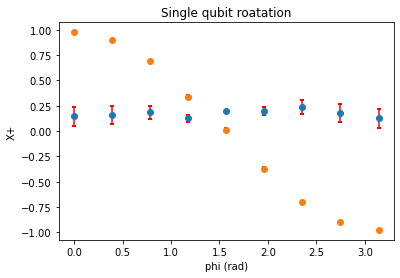

In [ ]:
# Create the plot
plt.errorbar(phi1,  xp_array_angle_s[: , 0], yerr= xp_array_angle_s[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')
plt.errorbar(phi1,  xp_array_angle_cl[: , 0], yerr= xp_array_angle_cl[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')

plt.xlabel('phi (rad)')
plt.ylabel('X+')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Single qubit roatation') 

plt.show()

### Save data in a file

In [ ]:

data = {
    'phi': phi1,
    'xp_s': xp_array_angle_s[: , 0],
    'xp_s_err': xp_array_angle_s[: , 1]/np.sqrt(n_rounds),
    'xp_cl': xp_array_angle_cl[: , 0],
    'xp_cl_err': xp_array_angle_cl[: , 1]/np.sqrt(n_rounds),

}


df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_xpfinal_phis_contrast100_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the data from a file and plot

In [9]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df['phi']
xp_s = df['xp_s']
xp_s_err= df['xp_s_err']
xp_cl = df['xp_cl']
xp_cl_err = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[1])

# Extract the columns you want to plot
phi_mu005 = df['phi']
xp_s_mu005 = df['xp_s']
xp_s_err_mu005 = df['xp_s_err']
xp_cl_mu005 = df['xp_cl']
xp_cl_err_mu005 = df['xp_cl_err']

# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[4])

# Extract the columns you want to plot
phi_contr4 = df['phi']
xp_s_contr4 = df['xp_s']
xp_s_err_contr4 = df['xp_s_err']
xp_cl_contr4 = df['xp_cl']
xp_cl_err_contr4 = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])

# Extract the columns you want to plot
phi_contr16 = df['phi']
xp_s_contr16 = df['xp_s']
xp_s_err_contr16 = df['xp_s_err']
xp_cl_contr16 = df['xp_cl']
xp_cl_err_contr16 = df['xp_cl_err']

file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[3])

# Extract the columns you want to plot
phi_contr100 = df['phi']
xp_s_contr100 = df['xp_s']
xp_s_err_contr100 = df['xp_s_err']
xp_cl_contr100 = df['xp_cl']
xp_cl_err_contr100 = df['xp_cl_err']




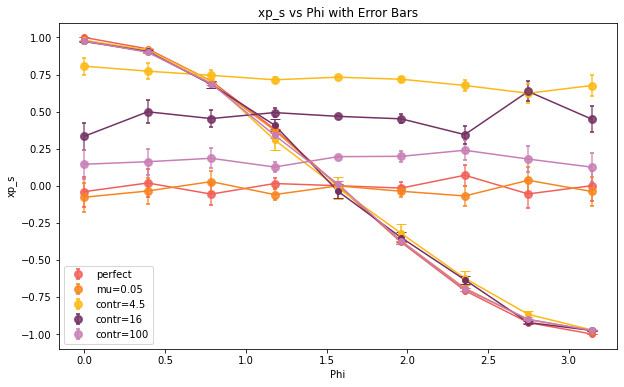

In [10]:
# Plot the data with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(phi, xp_s, yerr=xp_s_err,  fmt='o',
             color=c1,           # Marker edge color
             markerfacecolor=c1, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c1,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='perfect')
plt.plot(phi, xp_s, color=c1)
plt.errorbar(phi, xp_cl, yerr=xp_cl_err,color=c1, fmt='o', capsize=5)
plt.plot(phi, xp_cl, color=c1)


plt.errorbar(phi_mu005, xp_s_mu005, yerr=xp_s_err_mu005,  fmt='o',
             color=c2,           # Marker edge color
             markerfacecolor=c2, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c2,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='mu=0.05')
plt.plot(phi_mu005, xp_s_mu005, color=c2)
plt.errorbar(phi_mu005, xp_cl_mu005, yerr=xp_cl_err_mu005,color=c2, fmt='o', capsize=5)
plt.plot(phi_mu005, xp_cl_mu005, color=c2)

# Plot the data with error bars
plt.errorbar(phi_contr4, xp_s_contr4, yerr=xp_s_err_contr4,  fmt='o',
             color=c3,           # Marker edge color
             markerfacecolor=c3, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c3,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=4.5')
plt.plot(phi_contr4, xp_s_contr4, color=c3)

plt.errorbar(phi_contr4, xp_cl_contr4, yerr=xp_cl_err_contr4,color=c3, fmt='o', capsize=5)
plt.plot(phi_contr4, xp_cl_contr4, color=c3)

# Plot the data with error bars
plt.errorbar(phi_contr16, xp_s_contr16, yerr=xp_s_err_contr16,  fmt='o',
             color=c4,           # Marker edge color
             markerfacecolor=c4, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c4,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=16')
plt.plot(phi_contr16, xp_s_contr16, color=c4)

plt.errorbar(phi_contr16, xp_cl_contr16, yerr=xp_cl_err_contr16,color=c4, fmt='o', capsize=5)
plt.plot(phi_contr16, xp_cl_contr16, color=c4)

# Plot the data with error bars
plt.errorbar(phi_contr100, xp_s_contr100, yerr=xp_s_err_contr100,  fmt='o',
             color=c5,           # Marker edge color
             markerfacecolor=c5, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c5,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=100')
plt.plot(phi_contr100, xp_s_contr100, color=c5)


plt.errorbar(phi_contr100, xp_cl_contr100, yerr=xp_cl_err_contr100,color=c5, fmt='o', capsize=5)
plt.plot(phi_contr100, xp_cl_contr100, color=c5)

# Add labels and title
plt.xlabel('Phi')
plt.ylabel('xp_s')
plt.title('xp_s vs Phi with Error Bars')
plt.legend()

# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of errors

In [41]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

mu_list = np.linspace(0.001, 1, 5)
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0

n_rounds = 100
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

rho_ave_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_mu = np.empty((0, 2, 2), dtype=complex)

#phi list
for j in range(len(phi1)):
    phi1e = phi1[j]
    # my list
    rho_ave_cl_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_mu = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_mu = np.empty((0, 2, 2), dtype=complex)

    for i in range(len(mu_list)):
        mu = mu_list[i]
        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
                
        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_mu = np.append(rho_ave_s_mu, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_s_mu = np.append(rho_std_s_mu, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_mu = np.append(rho_ave_cl_mu, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_cl_mu = np.append(rho_std_cl_mu, [rho_std_cl], axis = 0)

    
    rho_ave_s_phi_mu = np.append(rho_ave_s_phi_mu, rho_ave_s_mu, axis = 0)
    rho_std_s_phi_mu = np.append(rho_std_s_phi_mu, rho_std_s_mu, axis = 0)

    rho_ave_cl_phi_mu = np.append(rho_ave_cl_phi_mu, rho_ave_cl_mu, axis = 0)
    rho_std_cl_phi_mu = np.append(rho_std_cl_phi_mu, rho_std_cl_mu, axis = 0)


Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345


#### Save density matrices 

In [43]:
data = {
    'rho_ave_s': [rho_ave_s_phi_mu],
    'rho_std_s': [rho_std_s_phi_mu],
    'rho_ave_cl': [rho_ave_cl_phi_mu],
    'rho_std_cl': [rho_std_cl_phi_mu]

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_rhos_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [75]:
import numpy as np
import pandas as pd
import ast
import re

# Function to clean and convert string to NumPy array, handling complex numbers
def clean_and_convert_to_array(s):
    # Clean up the string to ensure it's a valid Python expression
    # Remove 'array(' and the closing ')', but handle complex numbers carefully
    cleaned_str = s.strip()  # Remove any leading/trailing whitespace
    cleaned_str = re.sub(r'array\(', '', cleaned_str)  # Remove 'array('
    cleaned_str = re.sub(r'\)\s*$', '', cleaned_str)  # Remove closing ')'
    cleaned_str = re.sub(r'\s+', '', cleaned_str)  # Remove any unnecessary spaces
    cleaned_str = cleaned_str.replace('\n', '')  # Remove newlines
    print("Cleaned String:", cleaned_str)

    try:
        # Safely evaluate the string to convert it into a list of lists or array
        matrix = ast.literal_eval(cleaned_str)
        return np.array(matrix)
    except Exception as e:
        print(f"Conversion failed for: {s}, Error: {e}")
        return np.nan

file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_rhos_phis_contrast52_100pts_mulist_2024-08-17_18-13-51.csv'
# Read the DataFrame from the CSV file
df_loaded = pd.read_csv(file_path)

# Convert the string representations back to NumPy arrays
df_loaded['rho_ave_s'] = df_loaded['rho_ave_s'].apply(clean_and_convert_to_array)
df_loaded['rho_std_s'] = df_loaded['rho_std_s'].apply(clean_and_convert_to_array)
df_loaded['rho_ave_cl'] = df_loaded['rho_ave_cl'].apply(clean_and_convert_to_array)
df_loaded['rho_std_cl'] = df_loaded['rho_std_cl'].apply(clean_and_convert_to_array)

# Now df_loaded contains the matrices as NumPy arrays again
print(df_loaded)


Conversion failed for: [[[ 5.00000000e-01+0.00000000e+00j -2.99798813e-02+0.00000000e+00j]
  [-2.99798813e-02+0.00000000e+00j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j -6.98493973e-02+0.00000000e+00j]
  [-6.98493973e-02+0.00000000e+00j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j  5.80269155e-02+0.00000000e+00j]
  [ 5.80269155e-02+0.00000000e+00j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j -1.79464577e-02+0.00000000e+00j]
  [-1.79464577e-02+0.00000000e+00j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j  8.59635645e-02+0.00000000e+00j]
  [ 8.59635645e-02+0.00000000e+00j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j -3.53389912e-02+3.53327441e-02j]
  [-3.53389912e-02-3.53327441e-02j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000000e-01+0.00000000e+00j  4.40790732e-02-4.54738047e-02j]
  [ 4.40790732e-02+4.54738047e-02j  5.00000000e-01+0.00000000e+00j]]

 [[ 5.00000

In [72]:
df_loaded['rho_ave_s']

0    [[[ 5.00000000e-01+0.00000000e+00j -2.99798813...
Name: rho_ave_s, dtype: object

In [76]:
print("Cleaned String:", cleaned_str)


NameError: name 'cleaned_str' is not defined

#### Fidelity of the gates

In [35]:
#separate the results of the experiment 
 
rho_ave_cl_0_mu = rho_ave_cl_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = rho_ave_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = rho_ave_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = rho_ave_cl_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = rho_std_cl_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = rho_std_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = rho_std_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = rho_std_cl_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


In [36]:
## compare to ideal results

fid_phi_mu =  np.empty((0, 2), dtype=float)
fid_err_phi_mu =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_mu =  np.empty((0, 2), dtype=float)
    fid_err_mu =  np.empty((0, 2), dtype=float)
    for j in range(len(mu_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_mu = np.append(fid_mu, [output[0]])
        fid_err_mu = np.append(fid_err_mu, [abs(output[1])])
    fid_phi_mu = np.append(fid_phi_mu, [fid_mu])
    fid_err_phi_mu = np.append(fid_err_phi_mu, [fid_err_mu])


NameError: name 'calculate_fidelity_uncertainty' is not defined

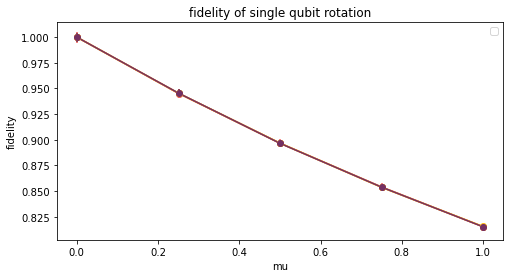

In [107]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)

#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')
plt.legend()

# Show the plot
plt.show()

### Save the data

In [84]:
data = {
    'fid': fid_phi_mu, 
    'yerr': fid_err_phi_mu,

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_fiderr_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'phi': phi1, 
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_philist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'mu': mu_list, 

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_mulist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the data

In [110]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleRot_Init_xp_contrast52_perfMWgates_vsMuerrors_for4phiangles/*contrast52*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])
df_phi = pd.read_csv(csv_file[1])
df_mu = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df_phi['phi']
mu = df_mu['mu']
fid = df['fid']
fid_err = df['yerr']


In [111]:
#separate the results of the experiment 

mu_list  = mu
phi_list  = phi


rho_ave_cl_0_mu = fid_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = fid_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = fid_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = fid_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = fid_err_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = fid_err_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = fid_err_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = fid_err_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


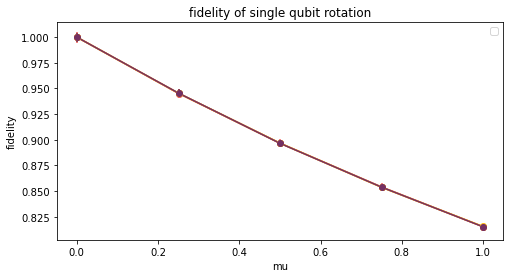

In [112]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)
#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')
plt.legend()

# Show the plot
plt.show()

In [37]:
def calculate_fidelity_uncertainty(rho, sigma, rho_errors):
    # Convert rho and sigma to Qobj if they are not already
    rho_qobj = qt.Qobj(rho)
    sigma_qobj = qt.Qobj(sigma)
    
    # Calculate fidelity
    F = (qt.fidelity(rho_qobj, sigma_qobj))**2
    
    # Calculate partial derivatives of fidelity with respect to each element of rho
    partial_F_rho = np.zeros(rho.shape)
    
    for i in range(rho.shape[0]):
        for j in range(rho.shape[1]):
            # Derivatives with respect to rho
            delta_rho = np.zeros(rho.shape)
            delta_rho[i, j] = 1e-6  # Small perturbation
            perturbed_fidelity = qt.fidelity(qt.Qobj(rho + delta_rho), sigma_qobj)**2
            partial_F_rho[i, j] = (perturbed_fidelity - F) / 1e-6
    
    # Calculate the uncertainty in fidelity
    uncertainty = np.sqrt(np.sum((partial_F_rho * rho_errors) ** 2))
    
    return F, uncertainty


#### Blindness of the gates

In [113]:
def calculate_holevo_quantity(probabilities, density_matrices):
    # Calculate the average density matrix
    avg_density_matrix = sum(p * rho for p, rho in zip(probabilities, density_matrices))
    
    # Calculate the von Neumann entropy of the average density matrix
    S_avg = qt.entropy_vn(qt.Qobj(avg_density_matrix))
    
    # Calculate the weighted sum of von Neumann entropies of each density matrix
    S_individual = sum(p * qt.entropy_vn(qt.Qobj(rho)) for p, rho in zip(probabilities, density_matrices))
    
    # Calculate the Holevo quantity
    chi = S_avg - S_individual
    
    return chi

def calculate_holevo_error(probabilities, density_matrices, density_matrix_errors, delta=1e-6):
    chi = calculate_holevo_quantity(probabilities, density_matrices)
    holevo_error = 0

    for k, rho in enumerate(density_matrices):
        partial_derivatives = np.zeros(rho.shape)
        
        for i in range(rho.shape[0]):
            for j in range(rho.shape[1]):
                perturbed_rho = rho.copy()
                perturbed_rho[i, j] += delta
                perturbed_chi = calculate_holevo_quantity(probabilities, [qt.Qobj(perturbed_rho) if idx == k else qt.Qobj(density_matrices[idx]) for idx in range(len(density_matrices))])
                
                partial_derivatives[i, j] = (perturbed_chi - chi) / delta
                
        # Sum the squared errors propagated through each partial derivative
        holevo_error += np.sum((partial_derivatives * density_matrix_errors[k]) ** 2)
    
    holevo_error = np.sqrt(holevo_error)
    
    return chi, holevo_error


In [114]:
# Define your probabilities and density matrices (example data)
probabilities = [0.5, 0.5]
density_matrices = [
    np.array([[0.9, 0.1], [0.1, 0.1]]),
    np.array([[0.85, 0.15], [0.15, 0.15]])
]
density_matrix_errors = [
    np.array([[0.01, 0.01], [0.01, 0.01]]),
    np.array([[0.02, 0.02], [0.02, 0.02]])
]

chi, chi_error = calculate_holevo_error(probabilities, density_matrices, density_matrix_errors)

print("Holevo Quantity:", chi)
print("Uncertainty in Holevo Quantity:", chi_error)


Holevo Quantity: 0.004066754655947802
Uncertainty in Holevo Quantity: 0.0020871553921892484


## Extra

In [ ]:
## Perfect single qubit gates with all init states and all final states

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

mu = 0.01
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = 0
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6

xp_array = np.empty((0, n_col), dtype=float)
xm_array = np.empty((0, n_col), dtype=float)
yp_array = np.empty((0, n_col), dtype=float)
ym_array = np.empty((0, n_col), dtype=float)
zp_array = np.empty((0, n_col), dtype=float)
zm_array = np.empty((0, n_col), dtype=float)

rho_init_xp_array = np.empty((2, 2), dtype=float)
rho_init_xm_array = np.empty((2, 2), dtype=float)
rho_init_yp_array = np.empty((2, 2), dtype=float)
rho_init_ym_array = np.empty((2, 2), dtype=float)
rho_init_zp_array = np.empty((2, 2), dtype=float)
rho_init_zm_array = np.empty((2, 2), dtype=float)

for i in range(n_rounds): 
    rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_xm, Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_yp, Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_ym, Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zp, Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zm, Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    
    rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
    rho_init_xm_array = np.append(rho_init_xm_array, rho_init_xm[0], axis = 0)
    rho_init_yp_array = np.append(rho_init_yp_array, rho_init_yp[0], axis = 0)
    rho_init_ym_array = np.append(rho_init_ym_array, rho_init_ym[0], axis = 0)
    rho_init_zp_array = np.append(rho_init_zp_array, rho_init_zp[0], axis = 0)
    rho_init_zm_array = np.append(rho_init_zm_array, rho_init_zm[0], axis = 0)

    xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
    yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
    ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
    zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
    zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


# Average the data and save as a dict

data = {
    '+ X mean': [np.mean(xp_array[:, i]) for i in range(6)],
    '+ X std': [np.std(xp_array[:, i], ddof=1) for i in range(6)],
    '- X mean': [np.mean(xm_array[:, i]) for i in range(6)],
    '- X std': [np.std(xm_array[:, i], ddof=1) for i in range(6)],
    '+ Y mean': [np.mean(yp_array[:, i]) for i in range(6)],
    '+ Y std': [np.std(yp_array[:, i], ddof=1) for i in range(6)],
    '- Y mean': [np.mean(ym_array[:, i]) for i in range(6)],
    '- Y std': [np.std(ym_array[:, i], ddof=1) for i in range(6)],
    '+ Z mean': [np.mean(zp_array[:, i]) for i in range(6)],
    '+ Z std': [np.std(zp_array[:, i], ddof=1) for i in range(6)],
    '- Z mean': [np.mean(zm_array[:, i]) for i in range(6)],
    '- Z std': [np.std(zm_array[:, i], ddof=1) for i in range(6)]
}

# Creating a DataFrame
df = pd.DataFrame(data)
df.columns = ['+ X mean', '+ X std', '- X mean', '- X std', '+ Y mean', '+ Y std', '- Y mean', '- Y std', '+ Z mean', '+ Z std', '- Z mean', '- Z std']

# Display the DataFrame
print("Table displayed in Python environment:")
print(df)

# # File path for the output CSV
# file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1{phi1}_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# # Write the DataFrame to a CSV file
# df.to_csv(file_path, index=False)


Table displayed in Python environment:
   + X mean   + X std  - X mean   - X std  + Y mean   + Y std  - Y mean  \
0  0.995525  0.000506 -0.995525  0.000506    0.0000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000    0.9956  0.000496 -0.995525   
2  0.000000  0.000000  0.000000  0.000000    0.0000  0.000000  0.000000   
3  0.050275  1.006921 -0.050275  1.006921    0.0000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000    0.1996  0.987813 -0.050275   
5  0.000000  0.000000  0.000000  0.000000    0.0000  0.000000  0.000000   

    - Y std  + Z mean  + Z std  - Z mean  - Z std  
0  0.000000       0.0      0.0       0.0      0.0  
1  0.000506       0.0      0.0       0.0      0.0  
2  0.000000       1.0      0.0      -1.0      0.0  
3  0.000000       0.0      0.0       0.0      0.0  
4  1.006921       0.0      0.0       0.0      0.0  
5  0.000000       1.0      0.0      -1.0      0.0  


In [ ]:
imperfections = {'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

cluster_state_length = 1
phi1 = 3*np.pi/2
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6
averphi3pi2 = []
mu_list = np.linspace(0.001, 0.7, num=2)
for mu in mu_list:
    print(mu)
    xp_array = np.empty((0, n_col), dtype=float)
    xm_array = np.empty((0, n_col), dtype=float)
    yp_array = np.empty((0, n_col), dtype=float)
    ym_array = np.empty((0, n_col), dtype=float)
    zp_array = np.empty((0, n_col), dtype=float)
    zm_array = np.empty((0, n_col), dtype=float)

    for i in range(n_rounds): 
        Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
        xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
        yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
        ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
        zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
        zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


    # Average the data and save as a dict
        
    data = {
        '+ X init': [f"{np.mean(xp_array[:, i]):.2f} ± {np.std(xp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- X init': [f"{np.mean(xm_array[:, i]):.2f} ± {np.std(xm_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Y init': [f"{np.mean(yp_array[:, i]):.2f} ± {np.std(yp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Y init': [f"{np.mean(ym_array[:, i]):.2f} ± {np.std(ym_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Z init': [f"{np.mean(zp_array[:, i]):.2f} ± {np.std(zp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Z init': [f"{np.mean(zm_array[:, i]):.2f} ± {np.std(zm_array[:, i], ddof=1):.2f}" for i in range(6)]
    }

    # i = 0
    # j = 1
    # k = 2

    # averphi0.append({np.mean([
    #     np.abs(np.mean(xp_array[:, i])),
    #     np.abs(np.mean(xm_array[:, i])),
    #     np.abs(np.mean(yp_array[:, j])),
    #     np.abs(np.mean(ym_array[:, j])),
    #     np.abs(np.mean(zp_array[:, k])),
    #     np.abs(np.mean(zm_array[:, k]))
    # ]), np.sqrt(np.sum([
    #     np.std(xp_array[:, i], ddof=1)**2,
    #     np.std(xm_array[:, i], ddof=1)**2,
    #     np.std(yp_array[:, j], ddof=1)**2,
    #     np.std(ym_array[:, j], ddof=1)**2,
    #     np.std(zp_array[:, k], ddof=1)**2,
    #     np.std(zm_array[:, k], ddof=1)**2
    # ])), })

    i = 1
    j = 0
    k = 2

    averphi3pi2.append({np.mean([
        np.abs(np.mean(xp_array[:, i])),
        np.abs(np.mean(xm_array[:, i])),
        np.abs(np.mean(yp_array[:, j])),
        np.abs(np.mean(ym_array[:, j])),
        np.abs(np.mean(zp_array[:, k])),
        np.abs(np.mean(zm_array[:, k]))
    ]), np.sqrt(np.sum([
        np.std(xp_array[:, i], ddof=1)**2,
        np.std(xm_array[:, i], ddof=1)**2,
        np.std(yp_array[:, j], ddof=1)**2,
        np.std(ym_array[:, j], ddof=1)**2,
        np.std(zp_array[:, k], ddof=1)**2,
        np.std(zm_array[:, k], ddof=1)**2
    ])), })

    # Creating a DataFrame
    df = pd.DataFrame.from_dict(data, orient = 'index')
    df.columns = ['X meas c', 'Y meas c', 'Z meas c', 'X meas s', 'Y meas s', 'Z meas s']

    # Display the DataFrame
    print("Table displayed in Python environment:")
    print(df)

    # File path for the output
    file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_{phi1:.1f}_{n_rounds}pts_mu{mu:.2f}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'

    # Write the DataFrame to a text file
    with open(file_path, 'w') as file:
        file.write(df.to_string(index=True))

0.001


ValueError: too many values to unpack (expected 6)

In [ ]:
averphi0

NameError: name 'averphi0' is not defined

In [ ]:
# save by hand

ave = [[[0.0, 1.0],[0.002016597794967225, 0.9759500000000001],[0.004044622894532245, 0.9533833333333334],[0.0050207901104640275, 0.9315625000000001],
 [0.007013448619506785, 0.910275],
 [0.008086709577749897, 0.8900666666666667],
 [0.01002880466840008, 0.8702916666666667],
 [0.011024651863798193, 0.8517125],
 [0.011038713925462755, 0.8336208333333334],
 [0.011711926859796854, 0.8153]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]], [[0.0, 1.0],
 [0.002016597794967225, 0.9759833333333333],
 [0.004008964314108433, 0.9531833333333334],
 [0.00500960615679056, 0.9315833333333333],
 [0.0070358058602099155, 0.91045],
 [0.00799487015016184, 0.8902000000000001],
 [0.010057526840821571, 0.8705833333333334],
 [0.010950529784631555, 0.8517583333333333],
 [0.011126199157497942, 0.8336666666666667],
 [0.011926699201629682, 0.81635]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]]]

In [ ]:
average_data = (np.array(ave)[0][:,1] + np.array(ave)[1][:,1] + np.array(ave)[2][:,1] + np.array(ave)[3][:,1])/4

In [ ]:
average_data

array([1.        , 0.97598333, 0.95330833, 0.93145312, 0.91051458,
       0.89006667, 0.87055208, 0.85186771, 0.83348854, 0.8159125 ])

Text(0.5, 1.0, 'Client side')

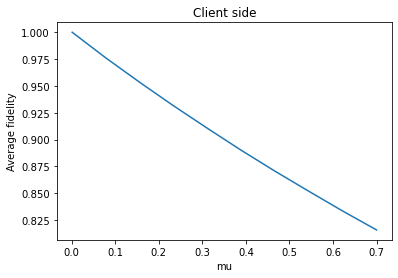

In [ ]:
plt.plot(mu_list, average_data, label = '')
plt.xlabel('mu')
plt.ylabel('Average fidelity')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Client side') 

In [ ]:
average = []

In [ ]:
np.append(average, averphi0)

array([{0.0, 1.0}, {0.9759500000000001, 0.002016597794967225},
       {0.9533833333333334, 0.004044622894532245},
       {0.9315625000000001, 0.0050207901104640275},
       {0.910275, 0.007013448619506785},
       {0.8900666666666667, 0.008086709577749897},
       {0.8702916666666667, 0.01002880466840008},
       {0.8517125, 0.011024651863798193},
       {0.8336208333333334, 0.011038713925462755},
       {0.8153, 0.011711926859796854}], dtype=object)

In [ ]:
## Calculate averages
file_path = '/Users/azizasuleymanzade/Dropbox (Personal)/AzizaOnly/LukinLab/BlindComputing/SimulationCode_Aziza/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_0.00_10pts_mu0.5_2024-05-01_23-47-59.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    print(line.strip())

parts = line.split('±')  # Split the string into parts

# Extract numbers from parts
mean = float(parts[0].strip())  # Convert the first part to float
std_dev = float(parts[1].strip())  # Convert the second part to float

print("Mean:", mean)
print("Standard Deviation:", std_dev)

X meas c      Y meas c      Z meas c      X meas s      Y meas s      Z meas s
+ X init   0.79 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -0.31 ± 0.77   0.00 ± 0.00   0.00 ± 0.00
- X init  -0.79 ± 0.01   0.00 ± 0.00   0.00 ± 0.00  -0.16 ± 0.82   0.00 ± 0.00   0.00 ± 0.00
+ Y init   0.00 ± 0.00   0.79 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -0.31 ± 0.77   0.00 ± 0.00
- Y init   0.00 ± 0.00  -0.80 ± 0.01   0.00 ± 0.00   0.00 ± 0.00  -0.16 ± 0.82   0.00 ± 0.00
+ Z init   0.00 ± 0.00   0.00 ± 0.00   1.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   1.00 ± 0.00
- Z init   0.00 ± 0.00   0.00 ± 0.00  -1.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -1.00 ± 0.00


ValueError: could not convert string to float: '- Z init   0.00'

In [ ]:
xp_array[:, 1]

array([-0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.])

In [ ]:
xp_array[:, 3]

array([-0.685, -0.685,  0.699, -0.685, -0.685, -0.685, -0.685,  0.699,
        0.699,  0.699])

In [ ]:
xp_array[:, 0]

array([0.685, 0.685, 0.699, 0.685, 0.685, 0.685, 0.685, 0.699, 0.699,
       0.699])